REDES NEURONALES

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo seleccionado: {device}")


Dispositivo seleccionado: cuda


In [45]:
# Cargar dataset
df = pd.read_excel("American Ninja Warrior Obstacle History.xlsx")
df.columns = df.columns.str.strip().str.replace(" ", "_")
df = df.sort_values(by=["Obstacle_Name", "Season"])

# Crear columna con próxima temporada del obstáculo
df["siguiente_temp"] = df.groupby("Obstacle_Name")["Season"].shift(-1)

# Etiqueta: volvió en la siguiente temporada
df["vuelve_en_siguiente"] = (df["siguiente_temp"] == df["Season"] + 1).astype(int)

# Filtrar filas válidas
df_entrenamiento = df.dropna(subset=["siguiente_temp"]).copy()

# Crear características agregadas
df_entrenamiento["apariciones_previas"] = df_entrenamiento.groupby("Obstacle_Name")["Season"].transform("count")
df_entrenamiento["orden_promedio"] = df_entrenamiento.groupby("Obstacle_Name")["Obstacle_Order"].transform("mean")
df_entrenamiento["etapas_diferentes"] = df_entrenamiento.groupby("Obstacle_Name")["Round/Stage"].transform("nunique")
df_entrenamiento["ubicaciones_diferentes"] = df_entrenamiento.groupby("Obstacle_Name")["Location"].transform("nunique")


In [160]:
X = df_entrenamiento[[
    "Season", "Obstacle_Order", "apariciones_previas",
    "orden_promedio", "etapas_diferentes", "ubicaciones_diferentes"
]]
y = df_entrenamiento["vuelve_en_siguiente"]

# Dividir
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Normalizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir a tensores
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).to(device)

# Dataloaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)


In [154]:
class MLPBinario(nn.Module):
    def __init__(self, input_size):
        super(MLPBinario, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)


In [155]:
class MLPRondas(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)

        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, num_classes)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x  # logits para CrossEntropyLoss


In [161]:
modelo = MLPBinario(input_size=X_train_tensor.shape[1]).to(device)
criterio = nn.CrossEntropyLoss()
optimizador = optim.Adam(modelo.parameters(), lr=0.003, weight_decay=1e-5)


In [162]:
def entrenar_modelo(modelo, train_loader, test_loader, criterio, optimizador, epocas=30):
    historial = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    
    for epoca in range(epocas):
        modelo.train()
        loss_total, correctos, total = 0, 0, 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizador.zero_grad()
            salida = modelo(X_batch).squeeze()
            loss = criterio(salida, y_batch)
            loss.backward()
            optimizador.step()
            
            loss_total += loss.item()
            pred = (salida > 0.5).float()
            correctos += (pred == y_batch).sum().item()
            total += y_batch.size(0)
        
        acc_train = 100 * correctos / total
        historial["train_loss"].append(loss_total / len(train_loader))
        historial["train_acc"].append(acc_train)

        # Validación
        modelo.eval()
        val_loss, val_correctos, val_total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                salida = modelo(X_batch).squeeze()
                loss = criterio(salida, y_batch)
                val_loss += loss.item()
                pred = (salida > 0.5).float()
                val_correctos += (pred == y_batch).sum().item()
                val_total += y_batch.size(0)
        
        acc_val = 100 * val_correctos / val_total
        historial["val_loss"].append(val_loss / len(test_loader))
        historial["val_acc"].append(acc_val)

        print(f"Época {epoca+1}: Precisión entrenamiento {acc_train:.2f}%, validación {acc_val:.2f}%")
    
    return historial


Época 1: Precisión entrenamiento 55.56%, validación 65.41%
Época 2: Precisión entrenamiento 63.65%, validación 72.18%
Época 3: Precisión entrenamiento 66.67%, validación 71.43%
Época 4: Precisión entrenamiento 69.11%, validación 68.42%
Época 5: Precisión entrenamiento 69.30%, validación 72.18%
Época 6: Precisión entrenamiento 66.67%, validación 69.17%
Época 7: Precisión entrenamiento 69.68%, validación 73.68%
Época 8: Precisión entrenamiento 69.49%, validación 72.93%
Época 9: Precisión entrenamiento 67.98%, validación 68.42%
Época 10: Precisión entrenamiento 67.23%, validación 70.68%
Época 11: Precisión entrenamiento 66.29%, validación 69.92%
Época 12: Precisión entrenamiento 66.29%, validación 70.68%
Época 13: Precisión entrenamiento 68.74%, validación 72.18%
Época 14: Precisión entrenamiento 67.61%, validación 74.44%
Época 15: Precisión entrenamiento 69.87%, validación 70.68%
Época 16: Precisión entrenamiento 66.48%, validación 72.18%
Época 17: Precisión entrenamiento 66.67%, validac

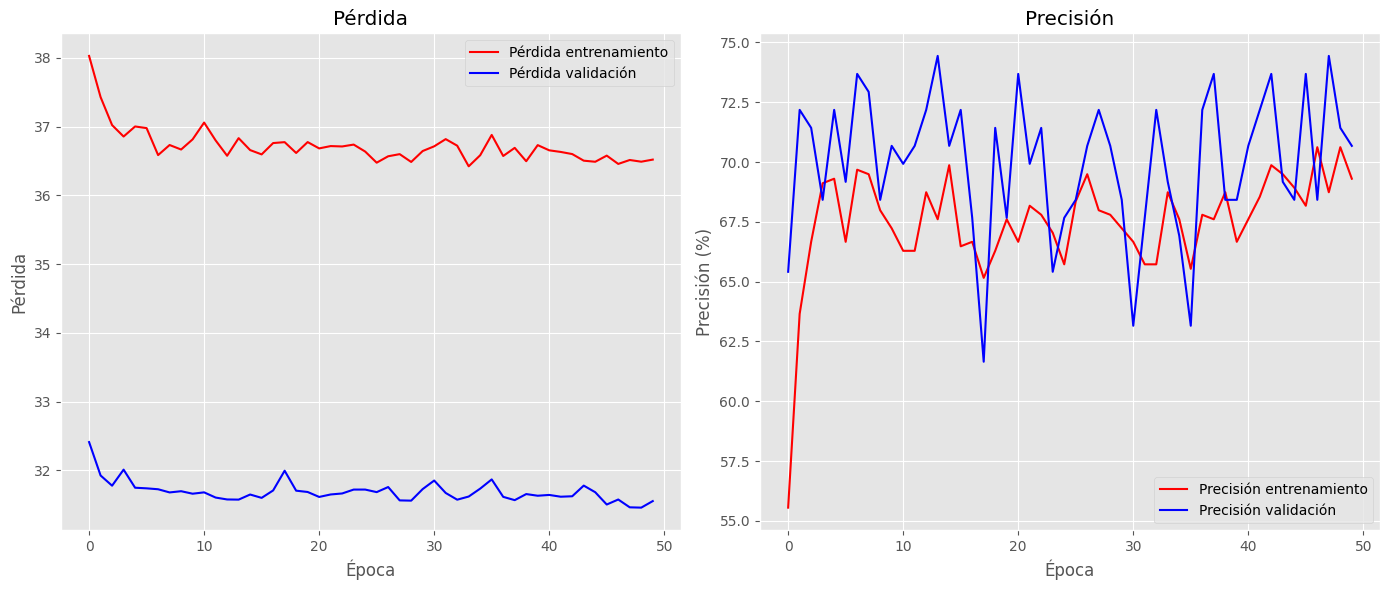

In [163]:
historial = entrenar_modelo(modelo, train_loader, test_loader, criterio, optimizador, epocas=50)

# Gráfica de pérdida y precisión lado a lado
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(historial["train_loss"], label="Pérdida entrenamiento", color="red")
plt.plot(historial["val_loss"], label="Pérdida validación", color="blue")
plt.title("Pérdida")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(historial["train_acc"], label="Precisión entrenamiento", color="red")
plt.plot(historial["val_acc"], label="Precisión validación", color="blue")
plt.title("Precisión")
plt.xlabel("Época")
plt.ylabel("Precisión (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [123]:
# Selección aleatoria de obstáculo
import random
nombre = random.choice(df["Obstacle_Name"].unique())
historial = df[df["Obstacle_Name"] == nombre]
ultima = historial.sort_values(by="Season", ascending=False).iloc[0]

# Simular temporada 11
entrada = pd.DataFrame([{
    "Season": 11,
    "Obstacle_Order": historial["Obstacle_Order"].mean(),
    "apariciones_previas": historial["Season"].count(),
    "orden_promedio": historial["Obstacle_Order"].mean(),
    "etapas_diferentes": historial["Round/Stage"].nunique(),
    "ubicaciones_diferentes": historial["Location"].nunique()
}])

entrada_escalada = scaler.transform(entrada)
entrada_tensor = torch.FloatTensor(entrada_escalada).to(device)

modelo.eval()
with torch.no_grad():
    prob = modelo(entrada_tensor).item()
    pred_binaria = int(prob > 0.5)

print(f"🔍 Obstáculo: {nombre}")
print(f"📅 Última aparición: Temporada {int(ultima['Season'])}")
print(f"🔮 Probabilidad de aparecer en T11: {prob:.2%}")
print(f"✅ Predicción: {'Sí aparecerá' if pred_binaria else 'No aparecerá'}")


🔍 Obstáculo: Spider Trap
📅 Última aparición: Temporada 10
🔮 Probabilidad de aparecer en T11: 18.91%
✅ Predicción: No aparecerá
